#### Assignment 3
For this assignment, I have chosen to solve the binary classification problem of determining whether a bank customer would churn or not depending on given features from the dataset Bank Customer Churn Dataset, located at https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset. This dataset has over 10,000 datapoints with 11 features each.

### Task 1:
To implement my two layer Neural Network, I will be inheriting from PyTorch's nn.Module to manage the weights of the layers during propagation and nn.Linear to represent the layers in the neural network. PyTorch also provides built in support for backpropagation and forward propagation by defining the forward function of a nn.Module and calling the backward() function call.
I will also be applying PyTorch's Dataloader module to facilitate the feeding of data into my neural network during the training process, which also requires the Dataset class, both obtainable from the torch.utils.data package.

In [1]:
#import the necessary packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Task 2:
Load the dataset and conduct exploratory data analysis.

In [2]:
bank_data = pd.read_csv("../../PIML/HW3/bank_churn.csv")
bank_data.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
#check for null data
bank_data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Since there are no entries with missing data, we can move on to replacing non-numerical entries with numerical entries

In [5]:
gender_to_num = {"Male": 0, "Female": 1}
bank_data.replace(gender_to_num, inplace = True)

countries = bank_data['country'].unique()
countries_to_num = {ct:idx for idx, ct in enumerate(countries)}
bank_data.replace(countries_to_num, inplace = True)

bank_data.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,1,1,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,1,1,43,2,125510.82,1,1,1,79084.10,0


In [6]:
#Normalize the dataset
def normalize(x):
    """
    Normalizes the data within dataframe x
    """
    x_norm = (x-x.min())/(x.max()-x.min())
    return x_norm

bank_data = normalize(bank_data)
bank_data.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,0.275616,0.538,0.0,1.0,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0
1,0.326454,0.516,0.5,1.0,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0
2,0.214421,0.304,0.0,1.0,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0
3,0.542636,0.698,0.0,1.0,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0
4,0.688778,1.000,0.5,1.0,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0


In [7]:
#drop inconsequential columns
bank_data.drop("customer_id", axis = 1, inplace = True)
bank_data.head(5)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,0.538,0.0,1.0,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0
1,0.516,0.5,1.0,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0
2,0.304,0.0,1.0,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0
3,0.698,0.0,1.0,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0
4,1.000,0.5,1.0,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0


In [8]:
#convert data from pandas to numpy
bank_data = bank_data.to_numpy()

Initialize the Dataset and Neural Network Modules

I will apply torch's ReLU activation process inbetween the two layers of the neural network to introduce sparsity. This activation function can be obtained from the torch.nn.functional package.

In [9]:
class NN(nn.Module):
    """
    Represents a two layer neural network
    """
    
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.dropout = nn.Dropout(p = 0.25)
        
    def forward(self, x):
        """
        This function handles the forwards propagation 
        process of the neural network.
        """
        #apply the first layer and the ReLU activation function.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #compute and the output layer
        x = self.fc2(x)
        
        return x

In [10]:
class BankData(du.Dataset):
    """
    Represents the data for the creditcard dataset and
    handles the passing of data during the training process
    """
    def __init__(self, bank_data):
        super(BankData, self).__init__()
        self.bank = bank_data
        
    def __len__(self):
        return self.bank.shape[0]
    
    def __getitem__(self, idx):
        """
        Finds and returns as a tensor the data for idx.
        """
        banks = self.bank[idx,:]
        bank_feats = torch.tensor(banks[:-1])
        bank_labels = torch.tensor(banks[-1])
        
        return bank_feats, bank_labels

In [11]:
#define training parameters
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using {device}")

batch_size = 1000
learning_rate = 0.0005
epochs = 5
in_dim = bank_data.shape[1]-1
hidden_dim = 8

using cpu


Split the data into train, validation, and test

In [12]:
#do a train/dev/test split of 75% 10% 15%
train_data, other = train_test_split(bank_data, test_size = 0.25)
valid_data, test_data = train_test_split(other, test_size = 0.4)

#make a copy of data for decision tree algorithm
train_data_cpy, test_data_cpy = train_data[:,:-1], test_data[:,:-1]
train_label_cpy, test_label_cpy = train_data[:,-1], test_data[:,-1]

For this model, I have decided to use an optimizer to alleviate the problem of vanishing and exploding gradients in the two layer MLP and prevent overfitting. I will also use the sigmoid activiation function to convert my predictions to 0 or 1 as I am trying to evaluate a classification problem. For loss, I will use functional's binary cross entropy with logits which applies sigmoid and calculates binary cross entropy loss. This function is more stable than simply applying sigmoid followed by BCE loss.

In [13]:
#initialize the model, dataset, dataloader, and optimizer
model = NN(in_dim, hidden_dim, 1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#initialize datasets
train_data = BankData(train_data)
valid_data = BankData(valid_data)
test_data = BankData(test_data)

#set up the dataloader
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=valid_data,
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=True)

#send the model to the device
model = model.to(device)
model.train()

NN(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Train the model and validate it

In [14]:
accs = []
eps = []
for epoch in range(1, epochs + 1):    
    sum_loss = 0.
    for batch_idx, (contexts, targets) in enumerate(train_loader):
        #send the data to the device
        contexts, targets = contexts.to(device), targets.to(device)
        
        #zero out prev gradients
        optimizer.zero_grad()
        
        #run the forward pass
        pred = model(contexts.float())
        
        #compute loss/error
        loss = F.binary_cross_entropy_with_logits(pred.float().squeeze(), targets.float())
        
        #sum up batch losses
        sum_loss += loss.item()
        
        # compute gradients and take a step
        loss.backward()
        optimizer.step()
        
    # average loss per example    
    sum_loss /= len(train_loader)
    
    #evaluate validation set
    with torch.no_grad():
        num_corr = 0
        for batch_idx, (contexts, targets) in enumerate(valid_loader):
            #send the data to the device
            contexts, targets = contexts.to(device), targets.to(device)

            #run the forward pass
            pred = model(contexts.float())
            
            #sigmoid and threshold the predictions
            pred = torch.sigmoid(pred)
            pred = torch.round(pred)
            
            #count the number of correct predictions
            num_corr += torch.sum(pred.float().squeeze() == targets.float())
            
        print(f"Epoch: {epoch}, Loss: {sum_loss:.6f}, Validation Accuracy: {num_corr/len(valid_loader.dataset):.6f}")
    accs.append(num_corr/len(valid_loader.dataset))
    eps.append(epoch)

Epoch: 1, Loss: 0.737604, Validation Accuracy: 0.315333
Epoch: 2, Loss: 0.726977, Validation Accuracy: 0.348667
Epoch: 3, Loss: 0.719433, Validation Accuracy: 0.400000
Epoch: 4, Loss: 0.709862, Validation Accuracy: 0.474667
Epoch: 5, Loss: 0.703461, Validation Accuracy: 0.500667


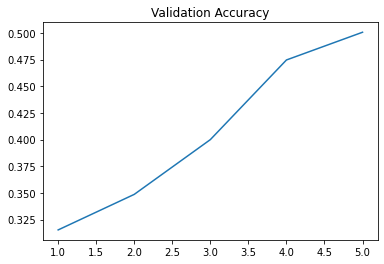

In [15]:
#plot the accuracy
plt.title("Validation Accuracy")
plt.plot(eps, accs)
plt.show()

Test the model

In [16]:
model.eval()

with torch.no_grad():
    num_corr = 0
    for batch_idx, (contexts, targets) in enumerate(test_loader):
        #send the data to the device
        contexts, targets = contexts.to(device), targets.to(device)

        #run the forward pass
        pred = model(contexts.float())

        #sigmoid and threshold the predictions
        pred = torch.sigmoid(pred)
        pred = torch.round(pred)

        #count the number of correct predictions
        num_corr += torch.sum(pred.float().squeeze() == targets.float())
            
    print(f"Test Accuracy: {num_corr/len(test_loader.dataset):.6f}")

Test Accuracy: 0.470000


### Task 3:
For my model, my parameters in_dim and out_dim were based on the expected input feature dimension and expected output feature dimension, which are 11 input features and 1 output feature(binary). I chose 8 to be my hidden dimension because by convention, the hidden dimension should be a power of 2 and 8 happened to be close to half of my input feature dimension. I used both dropout regularization and an optimizer to prevent the possiblity of overfitting and mitigate exploding/vanishing gradients, which did not end up occurring. I chose to use a low learning rate of 0.0005 because the neural network only has two layers so the speed of learning would not be impacted much and to reduce the possibility of gradient explosion. Though I initially chose 10 epochs, I found that the validation accuracy peaks at 5 epochs so I decided to reduce the number of epochs to 5. 

### Task 4:
For my baseline model, I will be applying scikit-learn's AdaBoost tree classifier to classify whether or not there is credit card fraud.

In [17]:
import sklearn
from sklearn.ensemble import AdaBoostClassifier

In [18]:
#fit and predict with the model
boost_model = AdaBoostClassifier(n_estimators=4, random_state=1, algorithm='SAMME')
boost_model.fit(train_data_cpy, train_label_cpy)
boost_pred = boost_model.predict(test_data_cpy)

In [19]:
#display the boosting accuracy
accuracy = np.sum(boost_pred == test_label_cpy)/test_label_cpy.shape[0]
print(f"Bagging Accuracy: {accuracy:.6f}")

Bagging Accuracy: 0.792000


In general, I found that the decision tree consistently outperforms the two layer neural network in terms of prediction accuracy. I believe the reason behind this is that with only 1 hidden layer and two layers in the neural network, unlike the decision tree which produces many splits to classify the input data, the neural network is not as capable of seeing diversity in the input data and therefore cannot generalize as well. On the other hand, the decision tree continues splitting and ends up making much more decisions compared to the neural network if we treat each node as a perceptrion and hence is able to generalize better. The scale of a two layer neural network is quite small while the scale of a decision tree is much, much larger.